# NEURAL STYLE TRANSFER USING VGG19


![alt text](examplestyletransfer.png "Title")

# Importing libraries to be used in the code

In [1]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
from keras.preprocessing.image import load_img, save_img, img_to_array
import argparse
from keras.applications import vgg19
from keras import backend as K
import matplotlib
import pandas as pd
import os 
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Module 1 :- Module to perform image handling operations like preprocessing, de-preprocessing, getting tensor image, create placeholder images.

In [2]:
class Style_Transfer_image_handler(object):
    '''
        All image specific loading and processing calculations will be performed in this module
    '''
    def __init__(self,image_width,image_height):
        self.image_width  = image_width          #also called columns
        self.image_height = image_height         # also called rows
        
    def preprocess_image(self,imagepath):
        '''
            This will be used as to input an image from a desired location and convert it to VGG19 suitable image 
            representation
        '''
        img = load_img(imagepath, target_size=(self.image_height, self.image_width))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = vgg19.preprocess_input(img)
        return img
    
    def deprocess_image(self,x):
        '''
            This method converts the BGR image output (from VGG19) to RGB that will be used in matplotlib for representation.
        '''
        x = x.reshape((self.image_height, self.image_width, 3))
        # Remove zero-center by mean pixel
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        # 'BGR'->'RGB'
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x
    
    def get_tensor_images(self,content_path,style_path):
        '''
            This method converts the image to variable tensors. 
            The content image representation will be used in the calculation of content loss where we will be comparing it 
            with another tensorflow variable instance(which will be our target image's tensor representation). 
            So both of them must be of same datatype.
            
            The style image representation will be used in calculation of the style loss. We will be using the same 
            representation of target image in form of tensorflow variable. 
        '''
        self.content_image         = K.variable(self.preprocess_image(content_path))
        self.style_image           = K.variable(self.preprocess_image(style_path))

    def create_placeholder_for_generated_image(self):
        '''
            We are creating a placeholder for the target image. We do not want to provide an initial value to 
            the image that will be generated, so we declare it to be a placeholder. We will use this placeholder construct
            and the variables style and content image representation from the previous method to minimize the loss. 
            We create an input tensor to be fed in the VGG19 model so as to capture the features at different layers.
        '''
        self.combination_image = K.placeholder((1, self.image_width, self.image_height, 3))
        self.input_tensor = K.concatenate([self.content_image,
                                      self.style_image,
                                      self.combination_image], axis=0)
        return self.input_tensor,self.combination_image

### Module 2:- Module to create a transfer learning model to extract features from

In [3]:
class Model_preparation(object):
    '''
        We create a model to be used for extracting the features. The outputs_dict will be the dictionary storing all the layers
        of the model and we will use the pretrained imagenet weights to create the model.
    '''
    def prepare_model(self,input_tensor):
        model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False,pooling='avg')
        outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
        return model,outputs_dict

### Module 3:- Module performing computation of the style loss, content loss and total variation loss of the target image generated.

In [4]:
class Compute_loss(object):
    '''
        Different losses will be computed over here in this class
    '''
    def gram_matrix(self,x):
        '''
            Computes the Gram matrix of one variable construct.
        '''
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
        gram = K.dot(features, K.transpose(features))
        return gram
    def style_loss(self,style_matrix, target_matrix,img_nrows,img_ncols):
        '''
            Computes the style loss between the style image and the target image
        '''
        S = self.gram_matrix(style_matrix)
        C = self.gram_matrix(target_matrix)
        channels = 3
        size = img_nrows * img_ncols
        return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

    def content_loss(self,content, target_matrix):
        '''
            Computes the content loss between the target image and the content image(base image)
        '''
        return K.sum(K.square(content - target_matrix))
    
    def total_variation_loss(self,x,img_nrows,img_ncols):
        '''
            Computes the total variation loss of the generated target image
        '''

        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:            , :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:            , :])
        return K.sum(K.pow(a + b, 1.25))
    


### Module 4:- Module to iteratively calculate the losses and gradients

In [5]:
    
class Evaluator(object):
    '''
        This class will act as an intermediary between successive iterations of BFGS calls.
    '''
    def __init__(self,loss,target_image,rows,columns):
        ## We specify how the gradients are to be calculated
        grads      = K.gradients(loss,variables = target_image)
        ## Initialzing the outputslist to contain loss 
        outputs    = [loss]
        if isinstance(grads, (list, tuple)):
            outputs = outputs + grads
        else:
            outputs.append(grads)
        
        ## We will put some placeholder tensors in the functional call and it will 
        ## return loss and gradients in form of an array
        self.f_outputs    = K.function(inputs = [target_image],outputs = outputs)
        self.loss_value   = None
        self.grads_values = None      
        self.img_nrows    = rows
        self.img_ncols    = columns
        
    def eval_loss_and_grads(self,x):
        '''
            This method will successively output the loss and gradients
        '''
        
        x          = x.reshape((1, self.img_nrows, self.img_ncols, 3))
        outs       = self.f_outputs([x])
        loss_value = outs[0]
        if len(outs[1:]) == 1:
            grad_values = outs[1].flatten().astype('float64')
        else:
            grad_values = np.array(outs[1:]).flatten().astype('float64')
        return loss_value, grad_values

    def loss(self, x):
        '''
            this method will output loss
        '''
        
        loss_value, grad_values = self.eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        '''
            This method will output gradients
        '''
        
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values



    

## Main computation begins here !

Step1:- Loading all necessary configuration files! 
Step1 completed!


Step2:- Loading content and style images and creating variables and tensors for the model
Instructions for updating:
Colocations handled automatically by placer.
Step2 completed and placeholder created for the target image!!


Step3:- Model preparation begins
Step3 completed !!
Step4:- Extracting the feature layers for content and style losses respectively!
Step4 Completed!
Step5:- Defining Loss functions!
Step5 Completed!!
Step 6:- Optimizing the losses! 
Iteration 0 completed in 5s
Iteration 10 completed in 2s
Iteration 20 completed in 2s
Iteration 30 completed in 3s
Iteration 40 completed in 2s
Iteration 50 completed in 2s
Iteration 60 completed in 2s
Iteration 70 completed in 2s
Iteration 80 completed in 2s
Iteration 90 completed in 2s
Iteration 100 completed in 2s
Iteration 110 completed in 2s
Iteration 120 completed in 2s
Iteration 130 completed in 2s
Iteration 140 completed in 2s
Iteration 150 completed in 2s

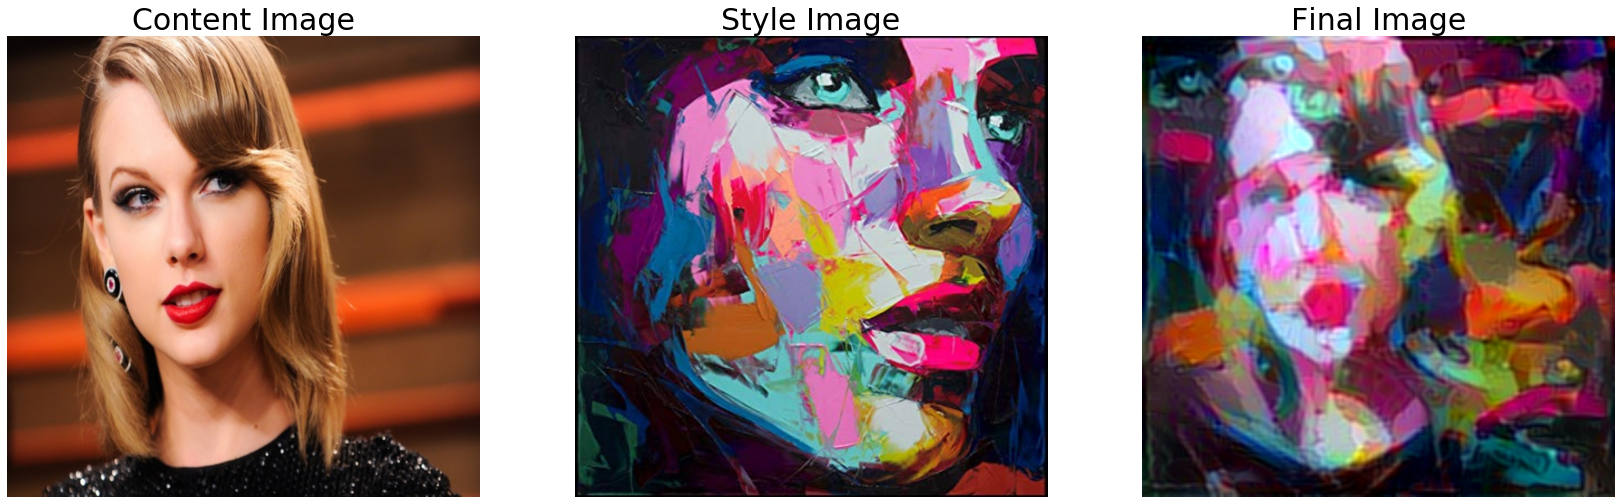

In [6]:
print('Step1:- Loading all necessary configuration files! ')
configs                        = pd.read_excel('configuration_sheet.xlsx',sheet_name='Style_transfer_vgg19',index_col='Parameter')
columns                        = configs.loc['Width'].values[0]
rows                           = configs.loc['Height'].values[0]
style_image                    = os.getcwd()+r'\styles'+'\\'+configs.loc['Style Image Name'].values[0]
content_image                  = os.getcwd()+r'\contents'+'\\'+configs.loc['Content Image Name'].values[0]
content_weight                 = configs.loc['Content Weight'].values[0]
style_weight_1                 = configs.loc['Style Weight 1'].values[0]
style_weight_2                 = configs.loc['Style Weight 2'].values[0]
style_weight_3                 = configs.loc['Style Weight 3'].values[0]
style_weight_4                 = configs.loc['Style Weight 4'].values[0]
style_weight_5                 = configs.loc['Style Weight 5'].values[0]
style_weight                   = [eval('style_weight_'+str(i+1)) for i in range(5)]
total_variation_weight         = configs.loc['Total Variation Weight'].values[0]
iterations                     = configs.loc['Iterations'].values[0]
print('Step1 completed!')
print('\n')
print('Step2:- Loading content and style images and creating variables and tensors for the model')
c                              = Style_Transfer_image_handler(rows,columns)
_                              = c.get_tensor_images(content_image,style_image)
input_tensor,target_image      = c.create_placeholder_for_generated_image()
print('Step2 completed and placeholder created for the target image!!')
print('\n')
print('Step3:- Model preparation begins')
prepare_model                  = Model_preparation()
model,outputs_dict             = prepare_model.prepare_model(input_tensor)
print('Step3 completed !!')
# we are extracting the content features of 2nd convolution of fifth block of VGG. Since we passed a concatenated tensor, 
# we must remember to separate the base(content image) and target image's features seperately before we put them in loss functions.
print('Step4:- Extracting the feature layers for content and style losses respectively!')
content_loss_features          = outputs_dict['block5_conv3']
base_image_features            = content_loss_features[0, :, :, :]
target_features                = content_loss_features[2, :, :, :]
print('Step4 Completed!')
# We are now specifying which layers to be used for style image feature extraction. We also specify the respective weights.
style_feature_layers           = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
style_feature_weights          = style_weight
content_weight                 = content_weight
total_variation_weight         = total_variation_weight
print('Step5:- Defining Loss functions!')
## We will be setting up the loss variable to be updated at each iteration of the functional call 
loss_functions                 = Compute_loss()
loss                           = K.variable(value = 0.0)  #loss value initialised to 0 
loss                           = loss  + content_weight * loss_functions.content_loss(base_image_features,target_features)
for layer_name,wts in zip(style_feature_layers,style_feature_weights):
    layer_features           = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    target_features          = layer_features[2, :, :, :]
    sl                       = loss_functions.style_loss(style_reference_features, target_features,rows,columns)
    loss                     = loss+ wts*sl
loss                         = loss+ total_variation_weight * loss_functions.total_variation_loss(target_image,rows,columns)
print('Step5 Completed!!')
## Calling the Evaluator module with loss and target_image as needed
evaluator                    = Evaluator(loss,target_image,rows,columns)
print('Step 6:- Optimizing the losses! ')
## Loading the content image 
x                            = c.preprocess_image(content_image)
img_vals                     = []
loss_vector                  = []
for i in range(iterations):
    #print('Start of iteration', i)
    start_time = time.time()
    
    ### performing optimization with loss as a function and considering gradients.
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    #print('Current loss value:', min_val)
    loss_vector.append(min_val)
    ### Saving every instance of the generated image
    img_vals.append(x)
    end_time = time.time()
    if i%10==0:
        print('Iteration %d completed in %ds' % (i, end_time - start_time))
imgx = c.deprocess_image(x.copy())
print('Step6 Complete!!')

plt.figure(figsize=(100,100))
plt.subplot(10,10,1)
plt.axis('off')
plt.title("Content Image",fontsize=30)
img_base = load_img(content_image)
plt.imshow(img_base,interpolation='gaussian',aspect='auto')
plt.subplot(10,10,1+1)
plt.axis('off')
plt.title("Style Image",fontsize=30)
img_style = load_img(style_image)
plt.imshow(img_style,interpolation='gaussian',aspect='auto')
plt.subplot(10,10,1+2)
plt.axis('off')
plt.title("Final Image",fontsize=30)
plt.imshow(imgx,interpolation='gaussian',aspect='auto')

## Printing the progression of target image formed

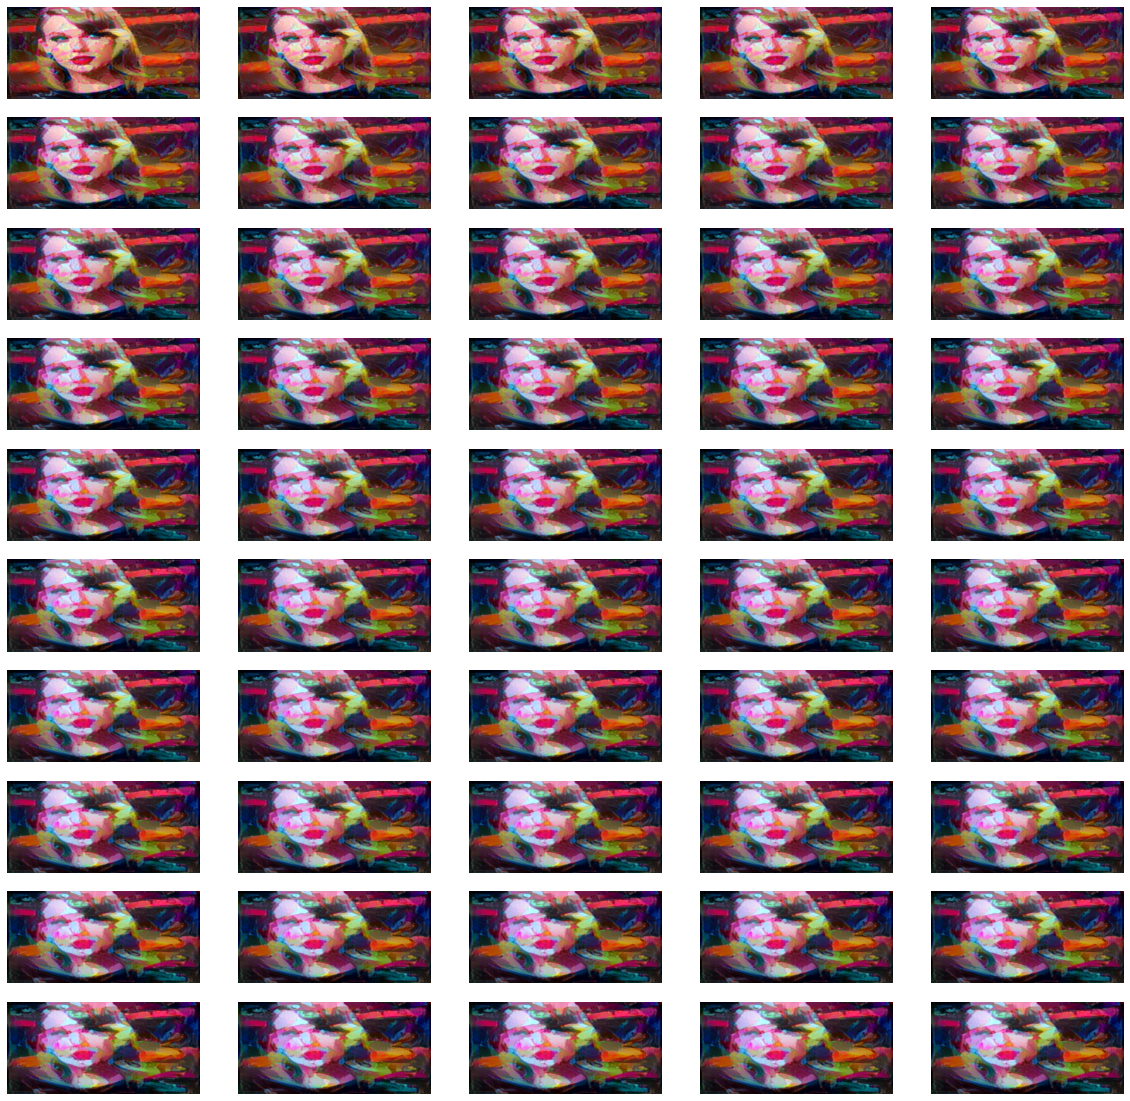

In [10]:
multiplier_subset = configs.loc['subset_multiplier'].values[0]
display_rows      = configs.loc['display_rows'].values[0]
display_columns   = configs.loc['display_columns'].values[0]
subset_progression = [img_vals[i] for i in range(1,len(img_vals)) if i%multiplier_subset==0]
fig=plt.figure(figsize=(20, 20))
columns = display_columns
rows = display_rows
for i in range(1, columns*rows +1):
    img = subset_progression[i-1]
    imgx = c.deprocess_image(img)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(imgx,interpolation='gaussian',aspect='auto')
plt.show()